In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import cross_fold
from midrc_dataset import midrc_challenge_dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import os
from sklearn.metrics import cohen_kappa_score
from get_model import create_model
from config import config
import numpy as np

%reload_ext autoreload
%autoreload 2

In [2]:
'''
    Train on 1 fold (1 dataset) with the input settings

    Returns: dict of training metrics
             best validation model is saved to \models
'''
def train(epochs,model,device, train_loader, val_loader, criterion, optimizer, fold_number):
    metrics={}
    best_vloss = 1_000_000.
    for e in range(epochs):
        print('EPOCH {}:'.format(e + 1))
        running_loss = 0.
        last_loss = 0.
        running_train_kappa=0.0
        avg_train_kappa=0.0
        model.train(True)

        for i, data in enumerate(train_loader):
            # Every data instance is an input + label pair
            inputs, labels = data

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs.to(device))
            labels=labels/24.0

            # Compute the loss and its gradients
            loss = criterion(outputs, labels.float().to(device).unsqueeze(1))
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            outputs=outputs*24.0
            labels=labels*24.0
            
            outputs=torch.round(outputs)
            outputs=outputs.data.cpu().numpy()
            
            labels=labels.data.cpu().numpy()
            outputs=outputs.flatten()
            labels=labels.flatten()
            kappa_score_train=cohen_kappa_score(labels,outputs,weights='quadratic')
            running_train_kappa+=kappa_score_train
            # Gather data
            running_loss += loss


        
        avg_loss = running_loss/(i+1)
        avg_train_kappa=running_train_kappa/(i+1)

        
        running_vloss = 0.0
        running_kappa = 0.0
        model.eval()
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs.to(device))
                vlabels=vlabels/24.0
                vloss = criterion(voutputs, vlabels.float().to(device).unsqueeze(1))
                voutputs=voutputs*24.0
                vlabels=vlabels*24.0
                voutputs=torch.round(voutputs)
                voutputs=voutputs.data.cpu().numpy()
                vlabels=vlabels.data.cpu().numpy()
                voutputs=voutputs.flatten()
                vlabels=vlabels.flatten()
                kappa_score=cohen_kappa_score(vlabels,voutputs,weights='quadratic')
                running_kappa+=kappa_score
                running_vloss += vloss
                

        avg_vloss = running_vloss / (i + 1)
        avg_val_kappa= running_kappa / (i + 1)

        
        print('LOSS train {} valid {}, Kappa train {} valid {}'.format(avg_loss,avg_vloss,avg_train_kappa,avg_val_kappa))
        metrics[e] = {      
            'avg_loss': avg_loss.item(),
            'avg_vloss': avg_vloss.item(),
            'avg_train_kappa': avg_train_kappa,
            'avg_val_kappa': avg_val_kappa
        }   

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = os.path.join('models','modelsave_fold_{}'.format(fold_number))
            torch.save(model.state_dict(), model_path)

    return metrics

In [3]:
def test(model,device,dataloader):
    model.eval()
    with torch.no_grad():
        squared_error = 0
        absolute_error = 0
        s_percent_error = 0
        kappa = 0
        kappa_list_y1 = []
        kappa_list_y2 = []

        for data in dataloader:
            inputs, labels = data

            outputs = model(inputs.to(device))
            labels=labels/24.0
            #print(labels.count)

            #squared_error += (outputs*torch.tensor(24.0).to(device) - labels.float().to(device).unsqueeze(1))**2
            #absolute_error += torch.abs(outputs*torch.tensor(24.0).to(device)-labels.float().to(device).unsqueeze(1))
            #percent_error += torch.abs((outputs*torch.tensor(24.0).to(device)-labels.float().to(device).unsqueeze(1))/labels.float().to(device).unsqueeze(1))

            squared_error += (outputs - labels.to(device))**2
            absolute_error += torch.abs(outputs-labels.to(device))
            s_percent_error += torch.abs((outputs-labels.to(device))/((labels.to(device) + outputs)/2))


            outputs=outputs*24.0
            labels=labels*24.0
            outputs=torch.round(outputs)
            outputs=outputs.data.cpu().numpy()
            labels=labels.data.cpu().numpy()
            outputs=outputs.flatten()
            labels=labels.flatten()

            kappa_list_y1.extend(labels)
            kappa_list_y2.extend(outputs)


        kappa = cohen_kappa_score(kappa_list_y1,kappa_list_y2,weights='quadratic')
            
        #returns mae and rmse
        return absolute_error/len(dataloader), torch.sqrt(squared_error/len(dataloader)), s_percent_error/len(dataloader), kappa

In [4]:
# Training Loop

folds = cross_fold.create_folded_datasets("../data/resized_224X224/label_info/labels.json")

root_dir = '../data/resized_224X224'

annotations_file = 'MIDRC mRALE Mastermind Training Annotations_2079_20230428.csv'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = config['batch_size']
epochs = config['epochs']


if config['augment']:
    # Define the transformations
    transform = transforms.Compose([
        transforms.RandomRotation(20),                           # Randomly rotate the image within -20 to +20 degrees
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),# Randomly crop and resize the image to 224x224 pixels
        transforms.RandomHorizontalFlip(),                       # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),                         # Randomly flip the image horizontally
        transforms.ToTensor()
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

val_transform = transforms.Compose([transforms.ToTensor()])


saved_metrics = []

for f_i,fold in enumerate(folds):
    print("FOLD: ",f_i+1)
    train_list, val_list = fold

    model = create_model(config=config)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters())

    criterion = torch.nn.MSELoss()

    train_dataset = midrc_challenge_dataset(root_dir, annotations_file, transform, fp_list = train_list)
    val_dataset = midrc_challenge_dataset(root_dir, annotations_file, val_transform, fp_list = val_list)
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    #Training per fold
    metrics = train(epochs,model,device,train_loader,val_loader, criterion, optimizer, f_i)
    saved_metrics.append(metrics)

Fold:  1  Train Indices:  2078  Val indices:  520
Fold:  2  Train Indices:  2096  Val indices:  502
Fold:  3  Train Indices:  2050  Val indices:  548
Fold:  4  Train Indices:  2072  Val indices:  526
Fold:  5  Train Indices:  2096  Val indices:  502
FOLD:  1
EPOCH 1:
LOSS train 0.09837006032466888 valid 0.08274707198143005, Kappa train 0.3605961501120536 valid 0.6380862346837433
EPOCH 2:
LOSS train 0.08133675903081894 valid 0.14117181301116943, Kappa train 0.5028131605988656 valid 0.08388937029432218
EPOCH 3:
LOSS train 0.06746343523263931 valid 0.1113230437040329, Kappa train 0.594586264962493 valid 0.522293456525292
EPOCH 4:
LOSS train 0.05264813452959061 valid 0.06474318355321884, Kappa train 0.7003659616476401 valid 0.6458960883875163
EPOCH 5:
LOSS train 0.0454980805516243 valid 0.05385035276412964, Kappa train 0.7448901710420097 valid 0.7062819804570243
EPOCH 6:
LOSS train 0.04292737692594528 valid 0.09129422903060913, Kappa train 0.7496059309637554 valid 0.5019915269100044
EPOCH 

In [5]:

#Testing Loop
for f_i,fold in enumerate(folds):

    train_list, val_list = fold

    val_dataset = midrc_challenge_dataset(root_dir, annotations_file, val_transform, fp_list = val_list)
    val_loader = DataLoader(val_dataset, batch_size = 1, shuffle=True)

    model = create_model(config)
    model_pth = os.path.join('models','modelsave_fold_{}'.format(f_i))
    model.load_state_dict(torch.load(model_pth))
    model.to(device)
    model.eval()

    avg_mae, avg_rmse, avg_smape, kappa = test(model,device,val_loader)

    print("Fold: ",f_i+1, " MAE:", avg_mae.item() , " RMSE: ", avg_rmse.item(), " sMAPE: ", avg_smape.item(), " Kappa: ", kappa)

Fold:  1  MAE: 0.14701972901821136  RMSE:  0.197721466422081  sMAPE:  0.6995524764060974  Kappa:  0.841319885147368
Fold:  2  MAE: 0.15210509300231934  RMSE:  0.2021886706352234  sMAPE:  0.7592952847480774  Kappa:  0.734993897281661
Fold:  3  MAE: 0.15506313741207123  RMSE:  0.2051122933626175  sMAPE:  0.7400298714637756  Kappa:  0.8203930942706129
Fold:  4  MAE: 0.16975799202919006  RMSE:  0.21931613981723785  sMAPE:  0.7490667104721069  Kappa:  0.7179738680295065
Fold:  5  MAE: 0.15526710450649261  RMSE:  0.21132703125476837  sMAPE:  0.8587353825569153  Kappa:  0.7897427968183617


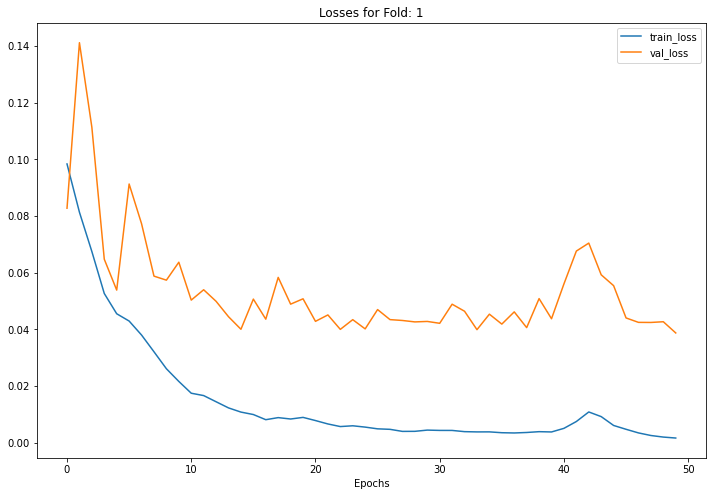

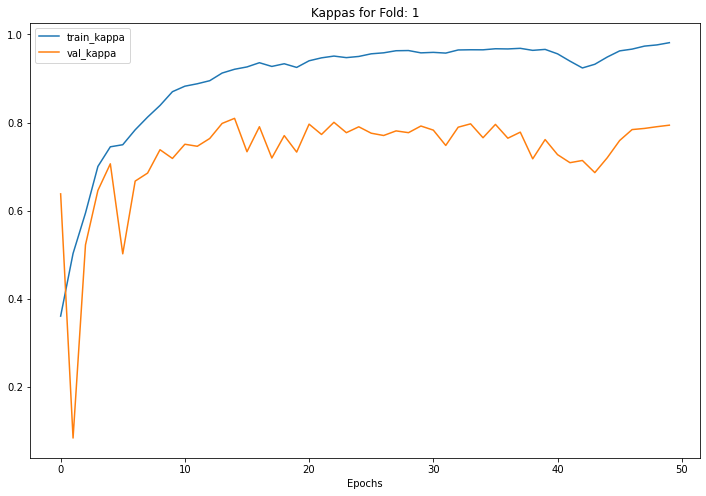

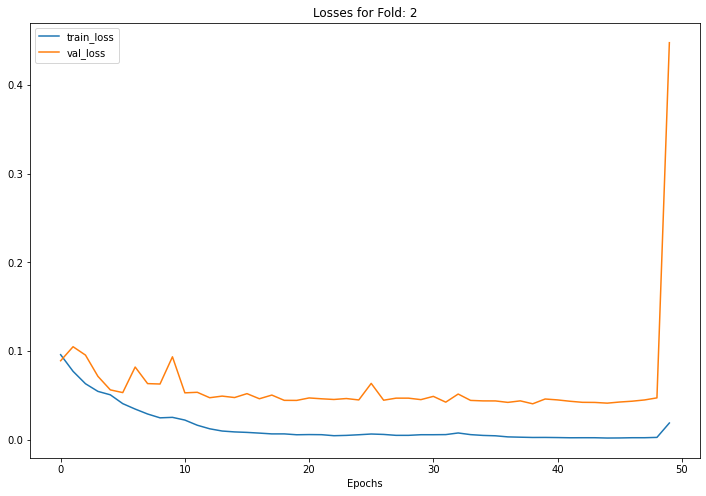

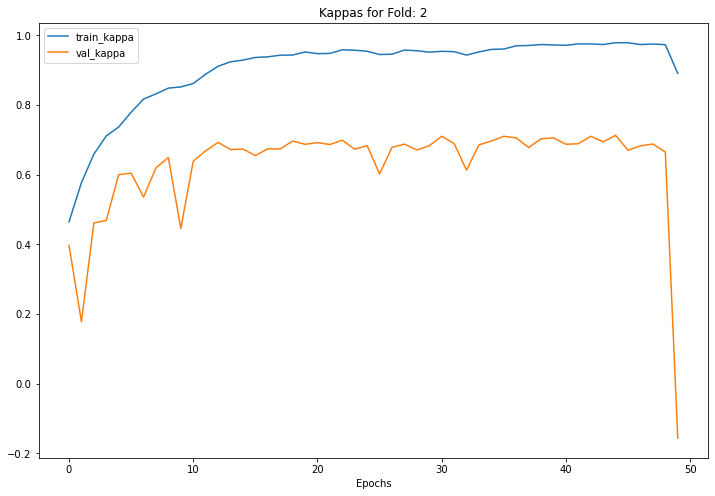

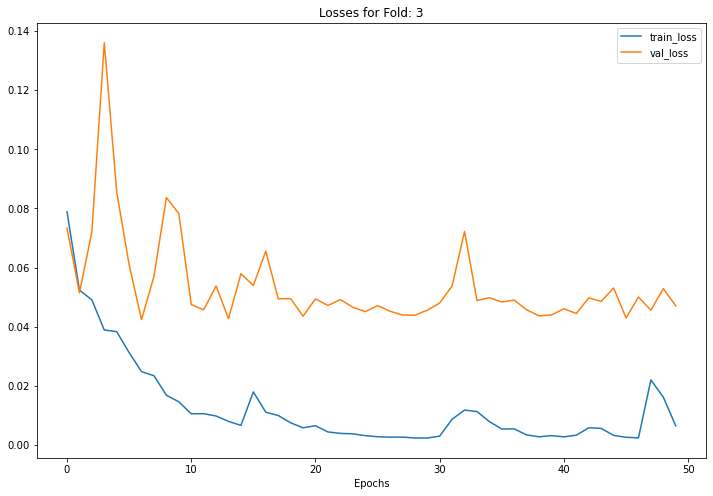

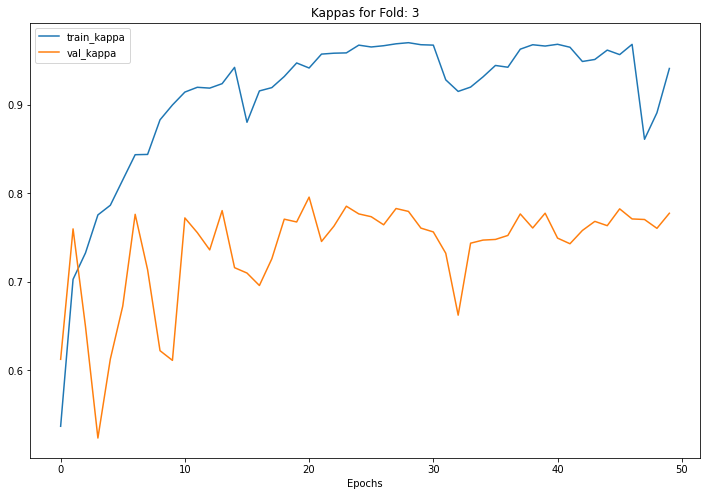

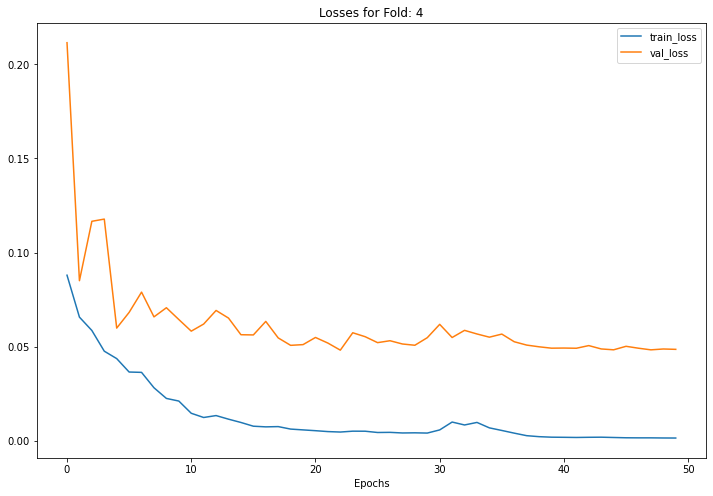

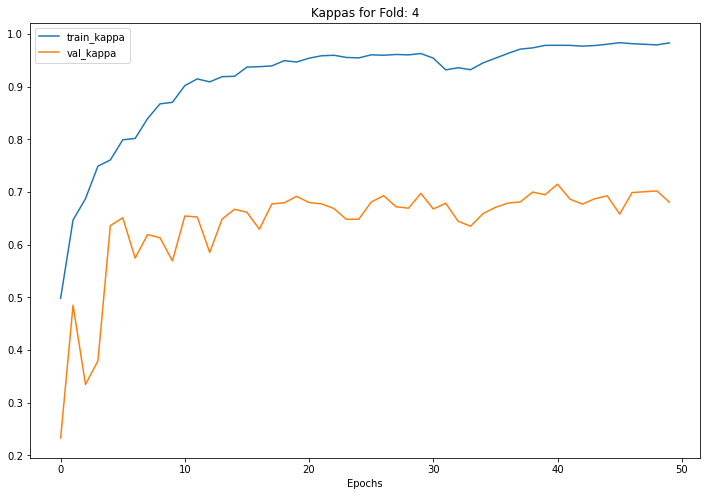

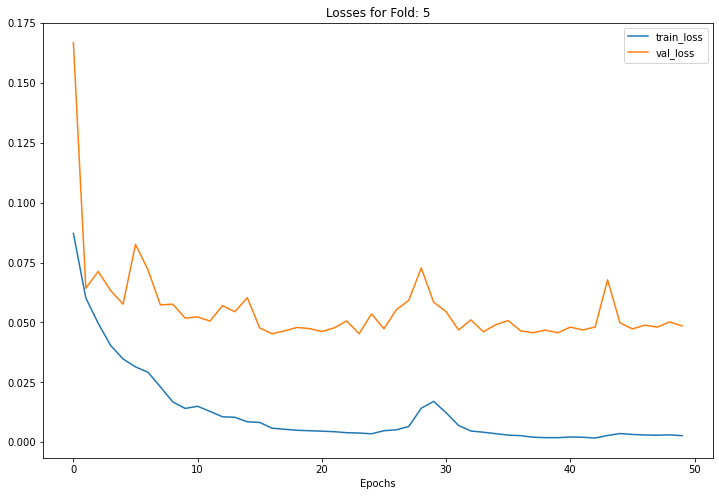

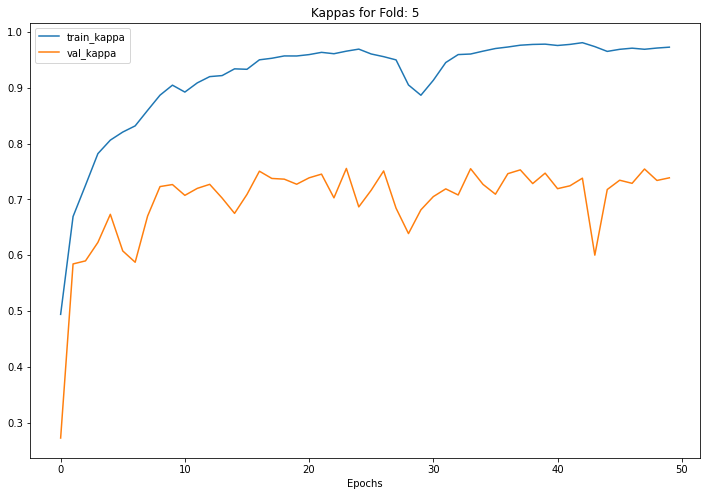

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

for f_i,fold in enumerate(folds):
    fold_metrics = saved_metrics[f_i]

    plt.figure(figsize=(12,8))
    plt.title("Losses for Fold: "+ str(f_i+1))
    plt.plot([fold_metrics[epoch]['avg_loss'] for epoch in metrics], label='train_loss')
    plt.plot([fold_metrics[epoch]['avg_vloss'] for epoch in metrics],label='val_loss')
    plt.legend()
    plt.xlabel("Epochs")
    filename = os.path.join("plots",str(f_i+1)+'_losses.png')
    plt.savefig(filename)
    plt.show()

    plt.figure(figsize=(12,8))
    plt.title("Kappas for Fold: "+ str(f_i+1))
    plt.plot([fold_metrics[epoch]['avg_train_kappa'] for epoch in metrics], label='train_kappa')
    plt.plot([fold_metrics[epoch]['avg_val_kappa'] for epoch in metrics],label='val_kappa')
    plt.legend()
    plt.xlabel("Epochs")
    filename = os.path.join("plots",str(f_i+1)+'_kappas.png')
    plt.savefig(filename)
    plt.show()